## 003 : Research Model with Data Augmentation

In [4]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np
from keras.models import load_model

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [5]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../41157150'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [7]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [8]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [9]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [7]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_from_previous_research_2class()
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 192)       196800    
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 192)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 192)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         442624    
__________

None

In [8]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 1 2 1 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 1 2 2
 2 1 2 2 2 1 1 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 1 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 1 2 2 1 2 2] [1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 2 2 2 2
 1 1 1 2 1 1 2 1 1 1 1 2 1 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1
 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2] [1 2 2 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 1 1 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2 1 1
 1 1 1 1 2 1 2 2 2 1 2 1 1 2 2 2 1 1 2 1 2 2 2 1 2 2 2 1 1 2 1 2 2 1 1 2 1
 2 2 2 1 2 1 1 1 2 2 2 1 2 1 1 2 2 1 1 1 2 1 2 1 2 2]


In [9]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

epochs2 = 6
batch_size2 = 64

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=45,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                     # Randomly zoom image 
        width_shift_range=0.15,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size2),
                              epochs = epochs2, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer()])

Epoch 1/6
2812/2812 [==============================] - 311s 111ms/step - loss: 0.1855 - acc: 0.9321 - val_loss: 1.5070 - val_acc: 0.8728
Epoch 2/6
2812/2812 [==============================] - 308s 110ms/step - loss: 0.1335 - acc: 0.9506 - val_loss: 0.9713 - val_acc: 0.8714
Epoch 3/6
2812/2812 [==============================] - 308s 110ms/step - loss: 0.0966 - acc: 0.9630 - val_loss: 1.2668 - val_acc: 0.8728
Epoch 4/6
2812/2812 [==============================] - 308s 110ms/step - loss: 0.0752 - acc: 0.9715 - val_loss: 1.2766 - val_acc: 0.8627
Epoch 5/6
2812/2812 [==============================] - 308s 110ms/step - loss: 0.0567 - acc: 0.9788 - val_loss: 1.3946 - val_acc: 0.8642

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/6
2812/2812 [==============================] - 308s 110ms/step - loss: 0.0305 - acc: 0.9884 - val_loss: 1.4766 - val_acc: 0.8671


Precision (specificity): 74.086%
Recall (sensitivity): 73.024%
Accuracy: 72.778%
F1: 72.533%


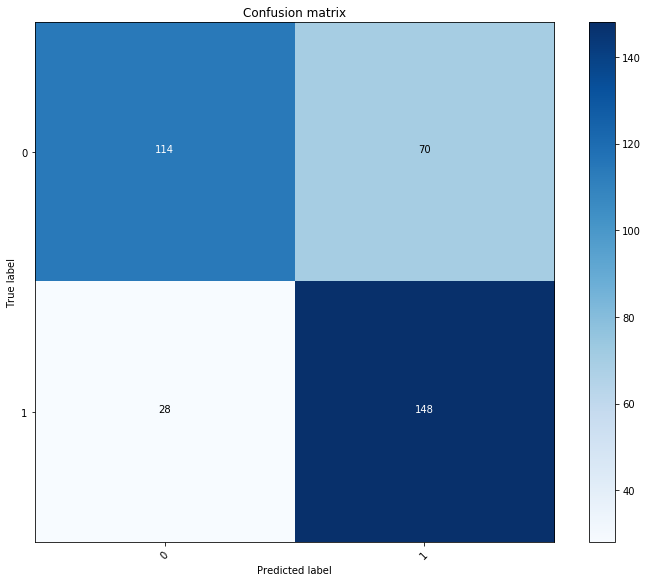

In [10]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [3]:
model = load_model('model_004_research_model_no_dropout.h5')

In [11]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

mdi-945f5ac6 [0.98309106 0.01749727] 0
mdi-df9a656f [0.91756755 0.08173576] 1
mdi-5e3d3832 [0.8456102  0.15362392] 0
mdi-1061cc91 [1.201433e-04 9.998132e-01] 1
mdi-b731a91f [0.06809484 0.9334443 ] 0
mdi-9abd4637 [2.7980455e-04 9.9974692e-01] 1


In [11]:
model.save('model_005_research_model_no_dropout.h5')